In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score
from google.colab import files
from torchsummary import summary
# import onnx
# from onnx2pytorch import ConvertModel
from tqdm import trange
from tqdm import tqdm
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model 1

In [3]:
balanced_path_data = 'drive/MyDrive/balanced_csic_data_64/training'
feature_extract = True

In [4]:
mean = torch.tensor([135.31470632, 124.53849418, 103.39646082])
std = torch.tensor([5.18153318, 4.14170719, 5.17011963])


transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [5]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load dataset
balanced_dataset = datasets.ImageFolder(balanced_path_data, transform=transform)
balanced_datasets = train_val_dataset(balanced_dataset)

class_dict = balanced_dataset.class_to_idx

In [6]:
batch_size = 32
balanced_dataloaders_dict = {x: torch.utils.data.DataLoader(balanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def train_model(model, dataloaders, criterion, optimizer,lr_scheduler,  num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    lrs = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)
                      
                      
                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()
                          

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  #getCategoricalAccuracy(preds, labels.data, class_dict)
                  running_corrects += torch.sum(preds == labels.data)

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
              if phase == 'train':
                lrs.append(optimizer.param_groups[0]["lr"])
                scheduler.step()
                print("Current Learning Rate = ",optimizer.param_groups[0]["lr"])


              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
              if phase == 'train':
                  train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [9]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
epoch = 100

### ResNet152 
pretrained on ImageNet and then fine-tuned on the CSIC data

In [10]:
model1 = models.resnet152(pretrained=True)
set_parameter_requires_grad(model1, True)
model1.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model1 = model1.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [11]:
params_to_update = model1.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model1.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model1.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
# optimizer = torch.optim.Adam(params_to_update, lr=1)
# lambda1 = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
optimizer = torch.optim.SGD(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training a pretrained Resnet18 on a balanced dataset
model1, model1_val_hist, model1_tr_hist  = train_model(model1, balanced_dataloaders_dict, criterion, optimizer,scheduler,  num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/99
----------


100%|██████████| 94/94 [12:36<00:00,  8.05s/batch]


train Loss: 7.6966 Acc: 0.4973
Current Learning Rate =  0.1


100%|██████████| 11/11 [01:24<00:00,  7.68s/batch]


val Loss: 4.2289 Acc: 0.3765

Epoch 1/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.84batch/s]


train Loss: 3.4940 Acc: 0.6436
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.19batch/s]


val Loss: 4.2105 Acc: 0.5000

Epoch 2/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.78batch/s]


train Loss: 3.3191 Acc: 0.6523
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.28batch/s]


val Loss: 4.9734 Acc: 0.7560

Epoch 3/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.78batch/s]


train Loss: 2.8564 Acc: 0.6794
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.32batch/s]


val Loss: 2.0223 Acc: 0.6446

Epoch 4/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.74batch/s]


train Loss: 2.2023 Acc: 0.7145
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.28batch/s]


val Loss: 3.4371 Acc: 0.6355

Epoch 5/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.37batch/s]


train Loss: 2.3767 Acc: 0.7035
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:02<00:00,  5.27batch/s]


val Loss: 1.4695 Acc: 0.7259

Epoch 6/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.64batch/s]


train Loss: 2.0336 Acc: 0.7383
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.06batch/s]


val Loss: 4.7905 Acc: 0.5873

Epoch 7/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.65batch/s]


train Loss: 1.9296 Acc: 0.7413
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.08batch/s]


val Loss: 6.6619 Acc: 0.5602

Epoch 8/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.93batch/s]


train Loss: 1.5618 Acc: 0.7624
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  6.08batch/s]


val Loss: 1.7593 Acc: 0.7319

Epoch 9/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.88batch/s]


train Loss: 2.6650 Acc: 0.7092
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.24batch/s]


val Loss: 1.2081 Acc: 0.7892

Epoch 10/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.97batch/s]


train Loss: 0.7675 Acc: 0.8313
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.29batch/s]


val Loss: 1.0309 Acc: 0.8223

Epoch 11/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.95batch/s]


train Loss: 0.7583 Acc: 0.8280
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.36batch/s]


val Loss: 1.0307 Acc: 0.8133

Epoch 12/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.97batch/s]


train Loss: 0.7500 Acc: 0.8347
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.39batch/s]


val Loss: 0.9608 Acc: 0.8283

Epoch 13/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.71batch/s]


train Loss: 0.7492 Acc: 0.8333
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  5.54batch/s]


val Loss: 0.9746 Acc: 0.8193

Epoch 14/99
----------


100%|██████████| 94/94 [00:15<00:00,  5.99batch/s]


train Loss: 0.7455 Acc: 0.8347
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:02<00:00,  4.63batch/s]


val Loss: 0.9410 Acc: 0.8163

Epoch 15/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.41batch/s]


train Loss: 0.7207 Acc: 0.8417
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  5.80batch/s]


val Loss: 0.9701 Acc: 0.8133

Epoch 16/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.41batch/s]


train Loss: 0.6511 Acc: 0.8457
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  5.82batch/s]


val Loss: 0.9632 Acc: 0.8133

Epoch 17/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.40batch/s]


train Loss: 0.6563 Acc: 0.8467
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  5.95batch/s]


val Loss: 0.8919 Acc: 0.8193

Epoch 18/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.45batch/s]


train Loss: 0.7017 Acc: 0.8417
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  5.99batch/s]


val Loss: 0.9217 Acc: 0.8193

Epoch 19/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.56batch/s]


train Loss: 0.6708 Acc: 0.8400
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 0.9142 Acc: 0.8072

Epoch 20/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6335 Acc: 0.8497
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 0.9031 Acc: 0.8163

Epoch 21/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.13batch/s]


train Loss: 0.6393 Acc: 0.8410
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 0.9162 Acc: 0.8072

Epoch 22/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.5950 Acc: 0.8544
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.49batch/s]


val Loss: 0.8785 Acc: 0.8193

Epoch 23/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.75batch/s]


train Loss: 0.6466 Acc: 0.8417
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.8953 Acc: 0.8253

Epoch 24/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6269 Acc: 0.8497
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.57batch/s]


val Loss: 0.8785 Acc: 0.8163

Epoch 25/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6176 Acc: 0.8427
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8812 Acc: 0.8102

Epoch 26/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6427 Acc: 0.8424
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8944 Acc: 0.8223

Epoch 27/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.22batch/s]


train Loss: 0.6482 Acc: 0.8430
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.74batch/s]


val Loss: 0.9009 Acc: 0.8133

Epoch 28/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.24batch/s]


train Loss: 0.6390 Acc: 0.8481
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.72batch/s]


val Loss: 0.9200 Acc: 0.8163

Epoch 29/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6381 Acc: 0.8440
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.54batch/s]


val Loss: 0.9051 Acc: 0.8193

Epoch 30/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.27batch/s]


train Loss: 0.6258 Acc: 0.8450
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 0.8897 Acc: 0.8223

Epoch 31/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6262 Acc: 0.8531
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.58batch/s]


val Loss: 0.8820 Acc: 0.8223

Epoch 32/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.22batch/s]


train Loss: 0.6553 Acc: 0.8377
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 0.9040 Acc: 0.8223

Epoch 33/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.83batch/s]


train Loss: 0.6269 Acc: 0.8417
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.78batch/s]


val Loss: 0.8782 Acc: 0.8133

Epoch 34/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.24batch/s]


train Loss: 0.6209 Acc: 0.8464
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 0.8644 Acc: 0.8253

Epoch 35/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.25batch/s]


train Loss: 0.6237 Acc: 0.8504
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8971 Acc: 0.8133

Epoch 36/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6184 Acc: 0.8501
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 0.8857 Acc: 0.8133

Epoch 37/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6201 Acc: 0.8471
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.8668 Acc: 0.8253

Epoch 38/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6275 Acc: 0.8474
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 0.8712 Acc: 0.8343

Epoch 39/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.23batch/s]


train Loss: 0.5888 Acc: 0.8514
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.8668 Acc: 0.8163

Epoch 40/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6208 Acc: 0.8450
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.54batch/s]


val Loss: 0.8819 Acc: 0.8133

Epoch 41/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.5940 Acc: 0.8497
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.72batch/s]


val Loss: 0.8929 Acc: 0.8102

Epoch 42/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.05batch/s]


train Loss: 0.6266 Acc: 0.8387
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:02<00:00,  5.12batch/s]


val Loss: 0.8901 Acc: 0.8313

Epoch 43/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6339 Acc: 0.8394
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.56batch/s]


val Loss: 0.8754 Acc: 0.8253

Epoch 44/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.22batch/s]


train Loss: 0.5729 Acc: 0.8527
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8832 Acc: 0.8283

Epoch 45/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6257 Acc: 0.8427
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8805 Acc: 0.8193

Epoch 46/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6125 Acc: 0.8430
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.71batch/s]


val Loss: 0.9030 Acc: 0.8283

Epoch 47/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.22batch/s]


train Loss: 0.6236 Acc: 0.8410
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 0.8802 Acc: 0.8133

Epoch 48/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6373 Acc: 0.8390
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8678 Acc: 0.8072

Epoch 49/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.17batch/s]


train Loss: 0.6493 Acc: 0.8461
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.72batch/s]


val Loss: 0.8637 Acc: 0.8133

Epoch 50/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6316 Acc: 0.8434
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 0.8710 Acc: 0.8193

Epoch 51/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6533 Acc: 0.8394
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 0.8809 Acc: 0.8193

Epoch 52/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.77batch/s]


train Loss: 0.6646 Acc: 0.8471
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.69batch/s]


val Loss: 0.8841 Acc: 0.8283

Epoch 53/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6162 Acc: 0.8477
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 0.8821 Acc: 0.8163

Epoch 54/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.5851 Acc: 0.8511
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8774 Acc: 0.8163

Epoch 55/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.24batch/s]


train Loss: 0.6146 Acc: 0.8424
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 0.8655 Acc: 0.8283

Epoch 56/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6410 Acc: 0.8440
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8913 Acc: 0.8102

Epoch 57/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6803 Acc: 0.8417
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8753 Acc: 0.8223

Epoch 58/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6237 Acc: 0.8377
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 0.8908 Acc: 0.7982

Epoch 59/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6297 Acc: 0.8410
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.73batch/s]


val Loss: 0.9041 Acc: 0.8193

Epoch 60/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6519 Acc: 0.8414
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.49batch/s]


val Loss: 0.9067 Acc: 0.8313

Epoch 61/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.83batch/s]


train Loss: 0.6137 Acc: 0.8417
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.31batch/s]


val Loss: 0.8972 Acc: 0.8223

Epoch 62/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.5974 Acc: 0.8491
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.68batch/s]


val Loss: 0.9033 Acc: 0.8253

Epoch 63/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.6123 Acc: 0.8461
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.60batch/s]


val Loss: 0.8972 Acc: 0.8223

Epoch 64/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.5875 Acc: 0.8491
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.43batch/s]


val Loss: 0.9019 Acc: 0.8133

Epoch 65/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.17batch/s]


train Loss: 0.6125 Acc: 0.8387
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.57batch/s]


val Loss: 0.8882 Acc: 0.8102

Epoch 66/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6113 Acc: 0.8477
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 0.8884 Acc: 0.8133

Epoch 67/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.21batch/s]


train Loss: 0.5996 Acc: 0.8521
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.62batch/s]


val Loss: 0.9190 Acc: 0.8193

Epoch 68/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6000 Acc: 0.8461
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 0.8775 Acc: 0.8283

Epoch 69/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.17batch/s]


train Loss: 0.6198 Acc: 0.8360
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.69batch/s]


val Loss: 0.9002 Acc: 0.8253

Epoch 70/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6253 Acc: 0.8491
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.73batch/s]


val Loss: 0.8896 Acc: 0.8072

Epoch 71/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.71batch/s]


train Loss: 0.6118 Acc: 0.8434
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8821 Acc: 0.8133

Epoch 72/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6512 Acc: 0.8367
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.53batch/s]


val Loss: 0.8963 Acc: 0.8223

Epoch 73/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6159 Acc: 0.8434
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.70batch/s]


val Loss: 0.8837 Acc: 0.8193

Epoch 74/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6429 Acc: 0.8377
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 0.8845 Acc: 0.8163

Epoch 75/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.20batch/s]


train Loss: 0.6420 Acc: 0.8387
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8761 Acc: 0.8283

Epoch 76/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6396 Acc: 0.8410
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.70batch/s]


val Loss: 0.8774 Acc: 0.8253

Epoch 77/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6268 Acc: 0.8457
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 0.8974 Acc: 0.8283

Epoch 78/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6119 Acc: 0.8417
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 0.8852 Acc: 0.8133

Epoch 79/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6084 Acc: 0.8447
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 0.9006 Acc: 0.8163

Epoch 80/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.76batch/s]


train Loss: 0.6235 Acc: 0.8384
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8721 Acc: 0.8133

Epoch 81/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6412 Acc: 0.8430
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8704 Acc: 0.8283

Epoch 82/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.5989 Acc: 0.8481
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.63batch/s]


val Loss: 0.8860 Acc: 0.8102

Epoch 83/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6203 Acc: 0.8444
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.58batch/s]


val Loss: 0.9212 Acc: 0.8072

Epoch 84/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.13batch/s]


train Loss: 0.6219 Acc: 0.8491
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.70batch/s]


val Loss: 0.8781 Acc: 0.8133

Epoch 85/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.14batch/s]


train Loss: 0.6154 Acc: 0.8454
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 0.8751 Acc: 0.8133

Epoch 86/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.5974 Acc: 0.8474
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8853 Acc: 0.8253

Epoch 87/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6264 Acc: 0.8450
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 0.9005 Acc: 0.8283

Epoch 88/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6193 Acc: 0.8467
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.8790 Acc: 0.8223

Epoch 89/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.77batch/s]


train Loss: 0.6128 Acc: 0.8410
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 0.9348 Acc: 0.8133

Epoch 90/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6198 Acc: 0.8491
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 0.8962 Acc: 0.8102

Epoch 91/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6315 Acc: 0.8454
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.64batch/s]


val Loss: 0.8964 Acc: 0.8163

Epoch 92/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.14batch/s]


train Loss: 0.6255 Acc: 0.8471
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]


val Loss: 0.9222 Acc: 0.8072

Epoch 93/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.16batch/s]


train Loss: 0.6295 Acc: 0.8484
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.59batch/s]


val Loss: 0.8950 Acc: 0.8223

Epoch 94/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.19batch/s]


train Loss: 0.6421 Acc: 0.8434
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.58batch/s]


val Loss: 0.8699 Acc: 0.8163

Epoch 95/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6393 Acc: 0.8437
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.55batch/s]


val Loss: 0.8597 Acc: 0.8253

Epoch 96/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6318 Acc: 0.8467
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.61batch/s]


val Loss: 0.8776 Acc: 0.8133

Epoch 97/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.15batch/s]


train Loss: 0.6308 Acc: 0.8370
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.57batch/s]


val Loss: 0.9102 Acc: 0.8133

Epoch 98/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.85batch/s]


train Loss: 0.6371 Acc: 0.8481
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  5.92batch/s]


val Loss: 0.8886 Acc: 0.8133

Epoch 99/99
----------


100%|██████████| 94/94 [00:13<00:00,  7.18batch/s]


train Loss: 0.6062 Acc: 0.8481
Current Learning Rate =  1.0000000000000006e-11


100%|██████████| 11/11 [00:01<00:00,  6.66batch/s]

val Loss: 0.8712 Acc: 0.8223

Training complete in 38m 55s
Best val Acc: 0.834337


# Model 2

In [12]:
path_to_model = 'drive/MyDrive/trained_models/deepweeds_resnet50_pretrained'
feature_extract = True

### ResNet50
pretrained on ImageNet fine-tuned on DeepWeeds and fine-tuned again on the CSIC *data*

In [14]:
path_to_model = 'drive/MyDrive/trained_models/resnet.hdf5'
import h5py
h5 = h5py.File(path_to_model, 'r')

# build model to map pretrained deepweeds model
model2 = models.resnet50()
set_parameter_requires_grad(model2, True)
model2.fc = nn.Linear(2048, 9)
model2.load_state_dict(h5, strict=False)

# change output later to map csic data
model2.fc = nn.Linear(2048, 4)

# load model to GPU
model2 = model2.to(device)

In [15]:
params_to_update = model2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(params_to_update, lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training a pretrained Resnet18 on a balanced dataset
model2, model2_val_hist, model2_tr_hist  = train_model(model2, balanced_dataloaders_dict, criterion, optimizer,scheduler,  num_epochs= epoch)

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.85batch/s]


train Loss: 55.1939 Acc: 0.4157
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  9.61batch/s]


val Loss: 81.5586 Acc: 0.5151

Epoch 1/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.78batch/s]


train Loss: 55.7749 Acc: 0.4153
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.91batch/s]


val Loss: 61.1906 Acc: 0.3524

Epoch 2/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.54batch/s]


train Loss: 48.9955 Acc: 0.4337
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  9.08batch/s]


val Loss: 12.3042 Acc: 0.4066

Epoch 3/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.61batch/s]


train Loss: 48.6211 Acc: 0.4294
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.42batch/s]


val Loss: 6.9391 Acc: 0.5964

Epoch 4/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.52batch/s]


train Loss: 44.4543 Acc: 0.4384
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.58batch/s]


val Loss: 22.0379 Acc: 0.6084

Epoch 5/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.19batch/s]


train Loss: 42.4316 Acc: 0.4528
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.19batch/s]


val Loss: 20.5554 Acc: 0.6325

Epoch 6/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.36batch/s]


train Loss: 39.8688 Acc: 0.4685
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.80batch/s]


val Loss: 37.0777 Acc: 0.5181

Epoch 7/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.78batch/s]


train Loss: 40.0603 Acc: 0.4565
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.75batch/s]


val Loss: 20.0239 Acc: 0.4578

Epoch 8/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.51batch/s]


train Loss: 33.7659 Acc: 0.4846
Current Learning Rate =  0.1


100%|██████████| 11/11 [00:01<00:00,  8.83batch/s]


val Loss: 64.7319 Acc: 0.5151

Epoch 9/99
----------


100%|██████████| 94/94 [00:09<00:00,  9.58batch/s]


train Loss: 36.2469 Acc: 0.4669
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  8.84batch/s]


val Loss: 29.1239 Acc: 0.5964

Epoch 10/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.32batch/s]


train Loss: 9.9866 Acc: 0.6586
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.59batch/s]


val Loss: 6.1743 Acc: 0.6205

Epoch 11/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.41batch/s]


train Loss: 5.5112 Acc: 0.6473
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.52batch/s]


val Loss: 6.1012 Acc: 0.6596

Epoch 12/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.45batch/s]


train Loss: 5.3297 Acc: 0.6496
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.37batch/s]


val Loss: 6.0701 Acc: 0.6416

Epoch 13/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.24batch/s]


train Loss: 5.2163 Acc: 0.6613
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.39batch/s]


val Loss: 6.0119 Acc: 0.6295

Epoch 14/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.14batch/s]


train Loss: 5.1557 Acc: 0.6647
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.49batch/s]


val Loss: 6.3119 Acc: 0.6175

Epoch 15/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.32batch/s]


train Loss: 5.0110 Acc: 0.6616
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.88batch/s]


val Loss: 5.9302 Acc: 0.6506

Epoch 16/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.46batch/s]


train Loss: 5.1541 Acc: 0.6533
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.92batch/s]


val Loss: 6.0272 Acc: 0.5633

Epoch 17/99
----------


100%|██████████| 94/94 [00:14<00:00,  6.61batch/s]


train Loss: 5.1341 Acc: 0.6442
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.02batch/s]


val Loss: 5.3104 Acc: 0.6145

Epoch 18/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.44batch/s]


train Loss: 4.7496 Acc: 0.6660
Current Learning Rate =  0.010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.91batch/s]


val Loss: 5.0045 Acc: 0.6355

Epoch 19/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.58batch/s]


train Loss: 4.8640 Acc: 0.6573
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.95batch/s]


val Loss: 5.0721 Acc: 0.6355

Epoch 20/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.52batch/s]


train Loss: 4.4264 Acc: 0.6754
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.84batch/s]


val Loss: 4.9295 Acc: 0.6416

Epoch 21/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.50batch/s]


train Loss: 4.4817 Acc: 0.6583
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  6.98batch/s]


val Loss: 4.8829 Acc: 0.6355

Epoch 22/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.74batch/s]


train Loss: 4.5281 Acc: 0.6606
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.37batch/s]


val Loss: 4.8501 Acc: 0.6325

Epoch 23/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.24batch/s]


train Loss: 4.4691 Acc: 0.6610
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.65batch/s]


val Loss: 4.8727 Acc: 0.6325

Epoch 24/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.34batch/s]


train Loss: 4.5021 Acc: 0.6780
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.63batch/s]


val Loss: 5.1770 Acc: 0.6476

Epoch 25/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.46batch/s]


train Loss: 4.3993 Acc: 0.6747
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  8.05batch/s]


val Loss: 5.0385 Acc: 0.6506

Epoch 26/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.42batch/s]


train Loss: 4.3920 Acc: 0.6707
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:02<00:00,  4.97batch/s]


val Loss: 4.7796 Acc: 0.6386

Epoch 27/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.89batch/s]


train Loss: 4.3560 Acc: 0.6807
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.87batch/s]


val Loss: 5.0169 Acc: 0.6536

Epoch 28/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.36batch/s]


train Loss: 4.4665 Acc: 0.6730
Current Learning Rate =  0.0010000000000000002


100%|██████████| 11/11 [00:01<00:00,  7.74batch/s]


val Loss: 4.8035 Acc: 0.6355

Epoch 29/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.49batch/s]


train Loss: 4.4036 Acc: 0.6737
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.74batch/s]


val Loss: 4.7829 Acc: 0.6386

Epoch 30/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.24batch/s]


train Loss: 4.4203 Acc: 0.6693
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.91batch/s]


val Loss: 4.7902 Acc: 0.6295

Epoch 31/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.29batch/s]


train Loss: 4.3513 Acc: 0.6717
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.22batch/s]


val Loss: 4.8489 Acc: 0.6476

Epoch 32/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.05batch/s]


train Loss: 4.4219 Acc: 0.6724
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.32batch/s]


val Loss: 4.6715 Acc: 0.6416

Epoch 33/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.35batch/s]


train Loss: 4.3777 Acc: 0.6680
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.59batch/s]


val Loss: 4.7821 Acc: 0.6325

Epoch 34/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.06batch/s]


train Loss: 4.2761 Acc: 0.6780
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.15batch/s]


val Loss: 4.8445 Acc: 0.6416

Epoch 35/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.11batch/s]


train Loss: 4.4070 Acc: 0.6714
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.24batch/s]


val Loss: 4.8886 Acc: 0.6476

Epoch 36/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.48batch/s]


train Loss: 4.3170 Acc: 0.6724
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.64batch/s]


val Loss: 4.8345 Acc: 0.6325

Epoch 37/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.45batch/s]


train Loss: 4.3759 Acc: 0.6663
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.52batch/s]


val Loss: 4.7971 Acc: 0.6295

Epoch 38/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.33batch/s]


train Loss: 4.2349 Acc: 0.6787
Current Learning Rate =  0.00010000000000000003


100%|██████████| 11/11 [00:01<00:00,  7.96batch/s]


val Loss: 4.9682 Acc: 0.6506

Epoch 39/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.35batch/s]


train Loss: 4.2445 Acc: 0.6787
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  7.77batch/s]


val Loss: 4.8184 Acc: 0.6325

Epoch 40/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.52batch/s]


train Loss: 4.2885 Acc: 0.6667
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  7.72batch/s]


val Loss: 4.8091 Acc: 0.6506

Epoch 41/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.58batch/s]


train Loss: 4.3453 Acc: 0.6663
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  7.67batch/s]


val Loss: 5.1261 Acc: 0.6506

Epoch 42/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.48batch/s]


train Loss: 4.5393 Acc: 0.6707
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.21batch/s]


val Loss: 4.9692 Acc: 0.6566

Epoch 43/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.04batch/s]


train Loss: 4.2464 Acc: 0.6720
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.40batch/s]


val Loss: 4.5311 Acc: 0.6355

Epoch 44/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.11batch/s]


train Loss: 4.3468 Acc: 0.6693
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.03batch/s]


val Loss: 4.7627 Acc: 0.6355

Epoch 45/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.00batch/s]


train Loss: 4.3698 Acc: 0.6734
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.35batch/s]


val Loss: 4.8743 Acc: 0.6386

Epoch 46/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.07batch/s]


train Loss: 4.3485 Acc: 0.6744
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.39batch/s]


val Loss: 4.8141 Acc: 0.6476

Epoch 47/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.15batch/s]


train Loss: 4.3714 Acc: 0.6690
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.41batch/s]


val Loss: 4.9569 Acc: 0.6416

Epoch 48/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.93batch/s]


train Loss: 4.4510 Acc: 0.6687
Current Learning Rate =  1.0000000000000004e-05


100%|██████████| 11/11 [00:01<00:00,  8.14batch/s]


val Loss: 4.7735 Acc: 0.6355

Epoch 49/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.09batch/s]


train Loss: 4.1085 Acc: 0.6891
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.06batch/s]


val Loss: 4.9446 Acc: 0.6446

Epoch 50/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.05batch/s]


train Loss: 4.2790 Acc: 0.6750
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.17batch/s]


val Loss: 4.7687 Acc: 0.6295

Epoch 51/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.17batch/s]


train Loss: 4.2834 Acc: 0.6744
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.24batch/s]


val Loss: 4.9434 Acc: 0.6355

Epoch 52/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.66batch/s]


train Loss: 4.4397 Acc: 0.6687
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  7.93batch/s]


val Loss: 5.0886 Acc: 0.6566

Epoch 53/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.03batch/s]


train Loss: 4.3832 Acc: 0.6707
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.05batch/s]


val Loss: 4.9230 Acc: 0.6536

Epoch 54/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.14batch/s]


train Loss: 4.3403 Acc: 0.6700
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.39batch/s]


val Loss: 4.7739 Acc: 0.6325

Epoch 55/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.21batch/s]


train Loss: 4.3578 Acc: 0.6780
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.17batch/s]


val Loss: 4.6069 Acc: 0.6416

Epoch 56/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.26batch/s]


train Loss: 4.2658 Acc: 0.6680
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.66batch/s]


val Loss: 4.8979 Acc: 0.6446

Epoch 57/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.20batch/s]


train Loss: 4.1553 Acc: 0.6730
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.36batch/s]


val Loss: 4.8543 Acc: 0.6416

Epoch 58/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.20batch/s]


train Loss: 4.3017 Acc: 0.6734
Current Learning Rate =  1.0000000000000004e-06


100%|██████████| 11/11 [00:01<00:00,  8.34batch/s]


val Loss: 4.8525 Acc: 0.6355

Epoch 59/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.81batch/s]


train Loss: 4.2505 Acc: 0.6707
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  8.31batch/s]


val Loss: 4.7640 Acc: 0.6295

Epoch 60/99
----------


100%|██████████| 94/94 [00:10<00:00,  9.07batch/s]


train Loss: 4.4436 Acc: 0.6613
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  8.34batch/s]


val Loss: 4.6168 Acc: 0.6506

Epoch 61/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.78batch/s]


train Loss: 4.3344 Acc: 0.6730
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  8.00batch/s]


val Loss: 4.7336 Acc: 0.6355

Epoch 62/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.82batch/s]


train Loss: 4.3529 Acc: 0.6660
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  8.11batch/s]


val Loss: 4.7947 Acc: 0.6355

Epoch 63/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.84batch/s]


train Loss: 4.5464 Acc: 0.6606
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  8.11batch/s]


val Loss: 4.8498 Acc: 0.6295

Epoch 64/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.57batch/s]


train Loss: 4.3547 Acc: 0.6703
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  7.79batch/s]


val Loss: 4.9920 Acc: 0.6446

Epoch 65/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.62batch/s]


train Loss: 4.4075 Acc: 0.6717
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  7.66batch/s]


val Loss: 4.7535 Acc: 0.6295

Epoch 66/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.14batch/s]


train Loss: 4.2056 Acc: 0.6841
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  7.55batch/s]


val Loss: 5.0533 Acc: 0.6536

Epoch 67/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.04batch/s]


train Loss: 4.4279 Acc: 0.6710
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  7.29batch/s]


val Loss: 4.8722 Acc: 0.6386

Epoch 68/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.99batch/s]


train Loss: 4.4727 Acc: 0.6650
Current Learning Rate =  1.0000000000000005e-07


100%|██████████| 11/11 [00:01<00:00,  7.34batch/s]


val Loss: 4.9193 Acc: 0.6476

Epoch 69/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.00batch/s]


train Loss: 4.2427 Acc: 0.6770
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.22batch/s]


val Loss: 4.8667 Acc: 0.6355

Epoch 70/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.89batch/s]


train Loss: 4.5858 Acc: 0.6673
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.19batch/s]


val Loss: 4.8141 Acc: 0.6386

Epoch 71/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.72batch/s]


train Loss: 4.3544 Acc: 0.6710
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.14batch/s]


val Loss: 4.8512 Acc: 0.6355

Epoch 72/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.83batch/s]


train Loss: 4.3627 Acc: 0.6667
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.31batch/s]


val Loss: 4.8152 Acc: 0.6355

Epoch 73/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.82batch/s]


train Loss: 4.2539 Acc: 0.6797
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.22batch/s]


val Loss: 4.7471 Acc: 0.6386

Epoch 74/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.01batch/s]


train Loss: 4.2138 Acc: 0.6804
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.25batch/s]


val Loss: 4.8564 Acc: 0.6295

Epoch 75/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.61batch/s]


train Loss: 4.4583 Acc: 0.6670
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.19batch/s]


val Loss: 4.8938 Acc: 0.6446

Epoch 76/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.98batch/s]


train Loss: 4.2843 Acc: 0.6730
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.32batch/s]


val Loss: 4.8064 Acc: 0.6325

Epoch 77/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.63batch/s]


train Loss: 4.4140 Acc: 0.6690
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  8.21batch/s]


val Loss: 4.8210 Acc: 0.6325

Epoch 78/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.90batch/s]


train Loss: 4.4151 Acc: 0.6633
Current Learning Rate =  1.0000000000000005e-08


100%|██████████| 11/11 [00:01<00:00,  7.92batch/s]


val Loss: 4.7345 Acc: 0.6386

Epoch 79/99
----------


100%|██████████| 94/94 [00:10<00:00,  8.86batch/s]


train Loss: 4.3789 Acc: 0.6780
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  8.01batch/s]


val Loss: 4.7423 Acc: 0.6416

Epoch 80/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.59batch/s]


train Loss: 4.3704 Acc: 0.6780
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.95batch/s]


val Loss: 4.8094 Acc: 0.6386

Epoch 81/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.54batch/s]


train Loss: 4.3018 Acc: 0.6710
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.47batch/s]


val Loss: 4.8280 Acc: 0.6386

Epoch 82/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.19batch/s]


train Loss: 4.4679 Acc: 0.6690
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.78batch/s]


val Loss: 4.9395 Acc: 0.6566

Epoch 83/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.08batch/s]


train Loss: 4.4513 Acc: 0.6730
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.16batch/s]


val Loss: 4.7866 Acc: 0.6386

Epoch 84/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.81batch/s]


train Loss: 4.5440 Acc: 0.6616
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.19batch/s]


val Loss: 4.7763 Acc: 0.6355

Epoch 85/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.93batch/s]


train Loss: 4.3636 Acc: 0.6697
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.46batch/s]


val Loss: 4.9005 Acc: 0.6355

Epoch 86/99
----------


100%|██████████| 94/94 [00:11<00:00,  8.01batch/s]


train Loss: 4.3670 Acc: 0.6707
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.31batch/s]


val Loss: 5.0067 Acc: 0.6596

Epoch 87/99
----------


100%|██████████| 94/94 [00:11<00:00,  7.91batch/s]


train Loss: 4.3457 Acc: 0.6693
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.18batch/s]


val Loss: 4.8758 Acc: 0.6325

Epoch 88/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.76batch/s]


train Loss: 4.2454 Acc: 0.6754
Current Learning Rate =  1.0000000000000005e-09


100%|██████████| 11/11 [00:01<00:00,  7.15batch/s]


val Loss: 4.8069 Acc: 0.6386

Epoch 89/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.59batch/s]


train Loss: 4.4940 Acc: 0.6747
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  7.13batch/s]


val Loss: 4.6378 Acc: 0.6386

Epoch 90/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.76batch/s]


train Loss: 4.3548 Acc: 0.6757
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.65batch/s]


val Loss: 4.6899 Acc: 0.6386

Epoch 91/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.75batch/s]


train Loss: 4.4872 Acc: 0.6710
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  7.24batch/s]


val Loss: 4.8064 Acc: 0.6416

Epoch 92/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.56batch/s]


train Loss: 4.3737 Acc: 0.6680
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  7.13batch/s]


val Loss: 4.9521 Acc: 0.6476

Epoch 93/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.69batch/s]


train Loss: 4.1656 Acc: 0.6780
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.75batch/s]


val Loss: 4.8856 Acc: 0.6506

Epoch 94/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.64batch/s]


train Loss: 4.3692 Acc: 0.6750
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  7.07batch/s]


val Loss: 4.8543 Acc: 0.6506

Epoch 95/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.63batch/s]


train Loss: 4.3427 Acc: 0.6647
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.91batch/s]


val Loss: 4.9173 Acc: 0.6355

Epoch 96/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.56batch/s]


train Loss: 4.4348 Acc: 0.6630
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  7.18batch/s]


val Loss: 4.6888 Acc: 0.6416

Epoch 97/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.51batch/s]


train Loss: 4.3501 Acc: 0.6714
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.89batch/s]


val Loss: 4.7386 Acc: 0.6416

Epoch 98/99
----------


100%|██████████| 94/94 [00:12<00:00,  7.65batch/s]


train Loss: 4.3450 Acc: 0.6784
Current Learning Rate =  1.0000000000000006e-10


100%|██████████| 11/11 [00:01<00:00,  6.78batch/s]


val Loss: 4.7380 Acc: 0.6416

Epoch 99/99
----------


100%|██████████| 94/94 [00:13<00:00,  6.74batch/s]


train Loss: 4.2735 Acc: 0.6690
Current Learning Rate =  1.0000000000000006e-11


100%|██████████| 11/11 [00:01<00:00,  7.14batch/s]

val Loss: 4.8416 Acc: 0.6446

Training complete in 21m 26s
Best val Acc: 0.659639


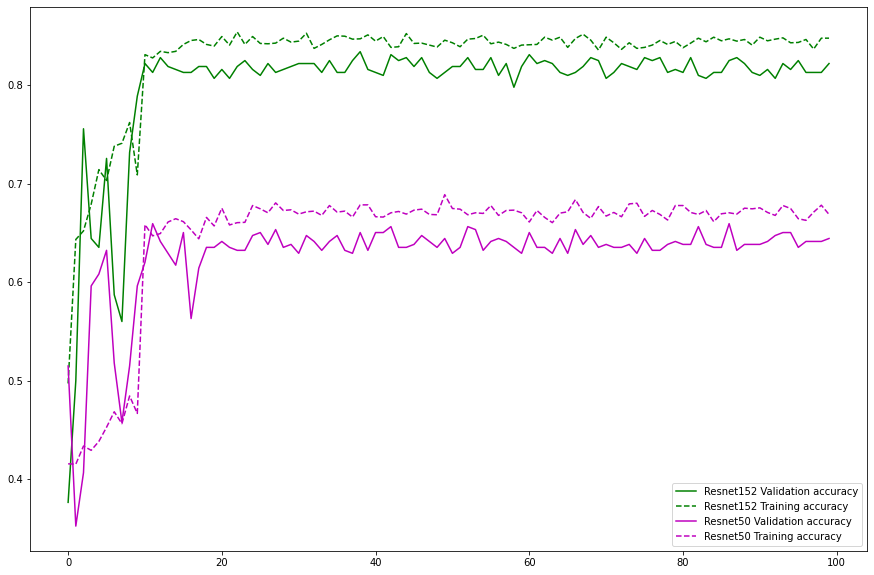

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Plotting traning and validation performance

model1_train_acc = []
for val in model1_tr_hist:
  model1_train_acc.append(val.cpu().data.numpy())

model1_val_acc = []
for val in model1_val_hist:
  model1_val_acc.append(val.cpu().data.numpy())

model2_train_acc = []
for val in model2_tr_hist:
  model2_train_acc.append(val.cpu().data.numpy())

model2_val_acc = []
for val in model2_val_hist:
  model2_val_acc.append(val.cpu().data.numpy())

plt.figure(figsize=(15,10))
plt.plot(model1_val_acc, 'g-', label='Resnet152 Validation accuracy')
plt.plot(model1_train_acc,'g--', label='Resnet152 Training accuracy')
plt.plot(model2_val_acc, 'm-', label='Resnet50 Validation accuracy')
plt.plot(model2_train_acc,'m--', label='Resnet50 Training accuracy')
plt.legend()
plt.savefig('best_models_lr_scheduler.png')
plt.show()
files.download('best_models_lr_scheduler.png')

# Testing the models

In [17]:
test_path_data = 'drive/MyDrive/balanced_csic_data_64/testing'
testing_dataset = torchvision.datasets.ImageFolder(test_path_data, transform=transform)
batch_size = 32
testing_dataloader =torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(testing_dataset.class_to_idx)

{'Cyperus': 0, 'Negative': 1, 'Portulaca': 2, 'Solanum': 3}


In [18]:
def getSensitivity(predictions, truth, nb_classes):
  
  conf_matrix = torch.zeros(nb_classes, nb_classes)
  for t, p in zip(truth, predictions):
      conf_matrix[t, p] += 1
      
  TP = conf_matrix.diag().sum()
  for c in range(nb_classes):
      idx = torch.ones(nb_classes).byte()
      idx[c] = 0
      # all non-class samples classified as non-class
      TN = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
      # all non-class samples classified as class
      FP = conf_matrix[idx, c].sum()
      # all class samples not classified as class
      FN = conf_matrix[c, idx].sum()
      sensitivity = TP/(TP+FN)
      specificity = TN/(TN+FP)
      print('Sensitivity for class {}:{}'.format(c, sensitivity))
      print('Specificity for class {}:{}'.format(c, specificity))



def getTestingMetrics(dataloader, model):
  # send model to GPU
  if torch.cuda.is_available():
    model.cuda()

  # with tqdm(testing_dataloader) as tepoch:
  lbs = []
  preds = []
  #   # Iterate over data.
  for inputs, labels in dataloader:
    test_inputs = inputs.to(device)
    #test_labels = labels.to(device)
    outputs = model(test_inputs)
    _, pred = torch.max(outputs, 1)
    lbs+=(list(labels.numpy()))
    preds+= list(pred.cpu().data.numpy())
  getSensitivity(preds, lbs, nb_classes = len(testing_dataset.class_to_idx))  
  print('Overall testing accuracy:',accuracy_score(lbs, preds))
  print(classification_report(lbs, preds, target_names=class_dict.keys()))

In [19]:
getTestingMetrics(testing_dataloader, model1)
getTestingMetrics(testing_dataloader, model2)

Sensitivity for class 0:0.9405099153518677
Specificity for class 0:0.8266423344612122
Sensitivity for class 1:0.9083447456359863
Specificity for class 1:0.9035294055938721
Sensitivity for class 2:0.9209431409835815
Specificity for class 2:0.9869281053543091
Sensitivity for class 3:0.9707602262496948
Specificity for class 3:0.9507389068603516
Overall testing accuracy: 0.7811764705882352
              precision    recall  f1-score   support

     Cyperus       0.73      0.86      0.79       302
    Negative       0.90      0.84      0.87       425
   Portulaca       0.74      0.33      0.46        85
     Solanum       0.31      0.47      0.38        38

    accuracy                           0.78       850
   macro avg       0.67      0.63      0.62       850
weighted avg       0.80      0.78      0.78       850



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  app.launch_new_instance()


Sensitivity for class 0:0.7666666507720947
Specificity for class 0:0.8266423344612122
Sensitivity for class 1:0.8816666603088379
Specificity for class 1:0.6729411482810974
Sensitivity for class 2:0.8981324434280396
Specificity for class 2:0.9633986949920654
Sensitivity for class 3:0.9480286836624146
Specificity for class 3:0.9273399114608765
Overall testing accuracy: 0.6223529411764706
              precision    recall  f1-score   support

     Cyperus       0.60      0.47      0.52       302
    Negative       0.72      0.83      0.77       425
   Portulaca       0.47      0.29      0.36        85
     Solanum       0.13      0.24      0.17        38

    accuracy                           0.62       850
   macro avg       0.48      0.46      0.46       850
weighted avg       0.62      0.62      0.62       850



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  app.launch_new_instance()
